<a href="https://colab.research.google.com/github/ksairos/tf-advanced-techniques-course/blob/main/course_4/C4_W3_Assignment_ANIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating ANIME faces with Variatioinal AutoEncoders

## Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

import os
import zipfile
import urllib.request
import random
from IPython import display

## Parameters

In [ ]:
# set a random seed
np.random.seed(51)

# parameters for building the model and training
BATCH_SIZE=2000
LATENT_DIM=512
IMAGE_SIZE=64

# define keras backend
K = tf.keras.backend

## Download Dataset

In [ ]:
# create a directory
try:
  os.mkdir('/tmp/anime')
except OSError:
  pass

# download the zipped dataset to just created directory
data_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Resources/anime-faces.zip"
data_file_name = "animefaces.zip"
download_dir = "/tmp/anime/"
urllib.request.urlretrieve(data_url, data_file_name)

# extract zip file
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

## Prepare dataset

In [ ]:
# Utilities

def get_dataset_slice_paths(image_dir):
  '''returns a list of paths to the image files'''
  image_file_list = os.listdir(image_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]

  return image_paths


def map_image(image_filename):
  '''preprocesses the images'''
  img_raw = tf.io.read_file(image_filename)
  image = tf.image.decode_jpeg(img_raw)

  image = tf.cast(image, dtype=tf.float32)
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  image = image / 255.0
  image = tf.reshape(image, shape=(IMAGE_SIZE, IMAGE_SIZE, 3, ))

  return image

In [ ]:
# get image paths list
paths = get_dataset_slice_paths(os.path.join(download_dir, 'images'))

# shuffle paths
random.shuffle(paths)

# split paths into training (80%) and validation (20%) sets
paths_len = len(paths)
train_paths_len = int(paths_len * 0.8)

train_paths = paths[:train_paths_len]
valid_paths = paths[train_paths_len:]

# load the training images into tenosors, shuffle and create batches
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths))
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(1024).batch(BATCH_SIZE)

# load the validation images into tenosors and create batches
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_paths))
valid_dataset = valid_dataset.map(map_image)
valid_dataset = valid_dataset.batch(BATCH_SIZE)

print(f'number of batches in the training set: {len(train_dataset)}')
print(f'number of batches in the validation set: {len(valid_dataset)}')

number of batches in the training set: 26
number of batches in the validation set: 7


## Display Utilities

In [ ]:
def display_faces(dataset, size=9):
  '''Takes {size} images from a dataset batch and plots it in a grid.'''
  dataset = dataset.unbatch().take(size)
  n_cols = 3
  n_rows = size // n_cols + 1
  plt.figure(figsize=(5,5))
  i = 0
  for image in dataset:
    i += 1
    disp_img = np.reshape(image, (IMAGE_SIZE, IMAGE_SIZE, 3))
    plt.subplot(n_rows, n_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(disp_img)


def display_one_row(disp_images, offset, shape=(28,28)):
  '''Displays a row of images.'''
  for idx, image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    image = np.reshape(image, shape)
    plt.imshow(image)


def display_results(disp_input_images, disp_predicted):
  '''Displays input and predicted images.'''
  plt.figure(figsize=(15,15))
  display_one_row(disp_input_images, 0, shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
  display_one_row(disp_predicted, 20, shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

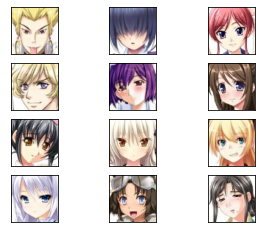

In [ ]:
display_faces(valid_dataset, 12)

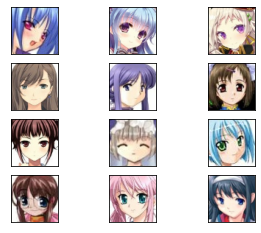

In [ ]:
display_faces(train_dataset, 12)

## Build the Model

Remind the structure of basic VAE

<img src="https://drive.google.com/uc?export=view&id=1YAZAeMGEJ1KgieYk1ju-S9DoshpMREeC" width="60%" height="60%"/>

### Sampling Class

In [ ]:
class Sampling(tf.keras.layers.Layer):
  def call(self, input):
    """Generates a random sample and combines with the encoder output
    
    Args:
      inputs -- output tensor from the encoder

    Returns:
      `inputs` tensors combined with a random sample
    """
    # get result of the Encoder
    mu, sigma = input

    # generate epsilon with random normal values
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.random.normal(shape=(batch, dim))

    z = mu + tf.math.exp( 0.5 * sigma ) * epsilon

    return z

### Encoder Layers

In [ ]:
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Flatten, Input, Reshape, Conv2DTranspose

def encoder_layers(inputs, latent_dim):
  """Defines the encoder's layers.
  Args:
    inputs -- batch from the dataset
    latent_dim -- dimensionality of the latent space

  Returns:
    mu -- learned mean
    sigma -- learned standard deviation
    batch_3.shape -- shape of the features before flattening
  """
  x = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu', name='encoder_conv1')(inputs)
  x = BatchNormalization()(x)

  x = Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu', name='encoder_conv2')(x)
  x = BatchNormalization()(x)

  x = Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu', name='encoder_conv3')(x)
  batch_3 = BatchNormalization()(x)

  x = Flatten(name="encoder_flatten")(batch_3)

  x = Dense(1024, activation='relu', name='encoder_dense')(x)
  x = BatchNormalization()(x)

  mu = Dense(latent_dim, name='latent_mu')(x)
  sigma = Dense(latent_dim, name='latent_sigma')(x)

  # revise `batch_3.shape` here if you opted not to use 3 Conv2D layers
  return mu, sigma, batch_3.shape

In [ ]:
def encoder_model(latent_dim, input_shape):
  """Defines the encoder model with the Sampling layer
  Args:
    latent_dim -- dimensionality of the latent space
    input_shape -- shape of the dataset batch

  Returns:
    model -- the encoder model
    conv_shape -- shape of the features before flattening
  """
  
  # initialize model input
  inputs = Input(shape=input_shape)
  
  # get results of the encoder layers 
  mu, sigma, conv_shape = encoder_layers(inputs, latent_dim)

  # feed mu and sigma into sampling layer
  z = Sampling()((mu, sigma))

  # build the encoder model
  model = tf.keras.Model(inputs=inputs, outputs=[mu, sigma, z])

  return model, conv_shape

In [ ]:
K.clear_session()

temp_encoder, _ = encoder_model(LATENT_DIM, (IMAGE_SIZE, IMAGE_SIZE, 3))
temp_encoder.summary()

del temp_encoder

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 encoder_conv1 (Conv2D)         (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['encoder_conv1[0][0]']          
 alization)                                                                                       
                                                                                                  
 encoder_conv2 (Conv2D)         (None, 16, 16, 64)   18496       ['batch_normalization[0][0]']

### Decoder Layers

In [ ]:
def decoder_layers(inputs, conv_shape):
  """Defines the decoder layers.
  Args:
    inputs -- output of the encoder 
    conv_shape -- shape of the features before flattening

  Returns:
    tensor containing the decoded output
  """

  # use conv_shape to make symmetrical decoder 
  input_shape = conv_shape[1] * conv_shape[2] * conv_shape[3]
  
  x = Dense(input_shape, activation='relu', name='decoder_dense')(inputs)
  x = BatchNormalization()(x)

  # Reshape resulting dense layer into conv_shape
  x = Reshape(target_shape=(conv_shape[1], conv_shape[2], conv_shape[3]), name='decoder_reshape')(x)

  x = Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same', name='decoder_deconv1')(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same', name='decoder_deconv2')(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same', name='decoder_deconv3')(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(3, kernel_size=3, strides=1, activation='sigmoid', padding='same', name='decoder_final_deconv')(x)
  
  return x

In [ ]:
def decoder_model(latent_dim, conv_shape):
  """Defines the decoder model.
  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening

  Returns:
    model -- the decoder model
  """

  inputs = Input(shape=(latent_dim))

  outputs = decoder_layers(inputs, conv_shape)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

In [ ]:
K.clear_session()

temp_decoder = decoder_model(LATENT_DIM, (None, 8, 8, 128))
temp_decoder.summary()

del temp_decoder

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 decoder_dense (Dense)       (None, 8192)              4202496   
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 decoder_reshape (Reshape)   (None, 8, 8, 128)         0         
                                                                 
 decoder_deconv1 (Conv2DTran  (None, 16, 16, 128)      147584    
 spose)                                                          
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512   

### Kullback–Leibler Divergence

In [ ]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
  """ Computes the Kullback-Leibler Divergence (KLD)
  Args:
    inputs -- batch from the dataset
    outputs -- output of the Sampling layer
    mu -- mean
    sigma -- standard deviation

  Returns:
    KLD loss
  """
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  return tf.reduce_mean(kl_loss) * -0.5

### Build the whole VAE model

In [ ]:
def vae_model(encoder, decoder, input_shape):
  """Defines the VAE model
  Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

  Returns:
    the complete VAE model
  """
  
  # Initialize input
  inputs = Input(shape=input_shape)

  # parse input through encoder layers
  mu, sigma, z = encoder(inputs)

  # parse through decoder
  reconstructed = decoder(z)

  model = tf.keras.Model(inputs=inputs, outputs=reconstructed)

  loss = kl_reconstruction_loss(inputs, z, mu, sigma)
  model.add_loss(loss)

  return model

In [ ]:
def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""
  encoder, conv_shape = encoder_model(latent_dim, input_shape)
  decoder = decoder_model(latent_dim, conv_shape) 
  vae = vae_model(encoder, decoder, input_shape)
  return encoder, decoder, vae

In [ ]:
K.clear_session()

encoder, decoder, vae = get_models(input_shape=(64,64,3,), latent_dim=LATENT_DIM)

In [ ]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 model (Functional)             [(None, 512),        9537472     ['input_3[0][0]']                
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                                  
 model_1 (Functional)           (None, 64, 64, 3)    4476867     ['model[0][2]']                  
                                                                                            

## Train the Model

In [ ]:
# Model Compilation

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
loss_metric = tf.keras.metrics.Mean()
mse_loss = tf.keras.losses.MeanSquaredError()
bse_loss = tf.keras.losses.BinaryCrossentropy()

In [ ]:
# utility function

def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """
  
  predictions = model.predict(test_input)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    img = predictions[i, :, :, :] * 255
    img = img.astype('int32')
    plt.imshow(img)
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

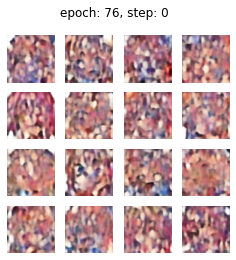

Epoch: 76 step: 0 mean loss = 231.4373
Epoch: 76 step: 1 mean loss = 231.38306
Epoch: 76 step: 2 mean loss = 231.32925
Epoch: 76 step: 3 mean loss = 231.2754
Epoch: 76 step: 4 mean loss = 231.22266
Epoch: 76 step: 5 mean loss = 231.17076
Epoch: 76 step: 6 mean loss = 231.11963
Epoch: 76 step: 7 mean loss = 231.06644
Epoch: 76 step: 8 mean loss = 231.01389


KeyboardInterrupt: ignored

In [ ]:
# Training loop. Display generated images each epoch

epochs = 100

random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      
      reconstructed = vae(x_batch_train)
      
      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])

      loss = mse_loss(flattened_inputs, flattened_outputs) * 64 * 64 * 3

      loss += sum(vae.losses)

    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))
    
    loss_metric(loss)

    if step % 10 == 0:
      display.clear_output(wait=False)    
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
    print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))

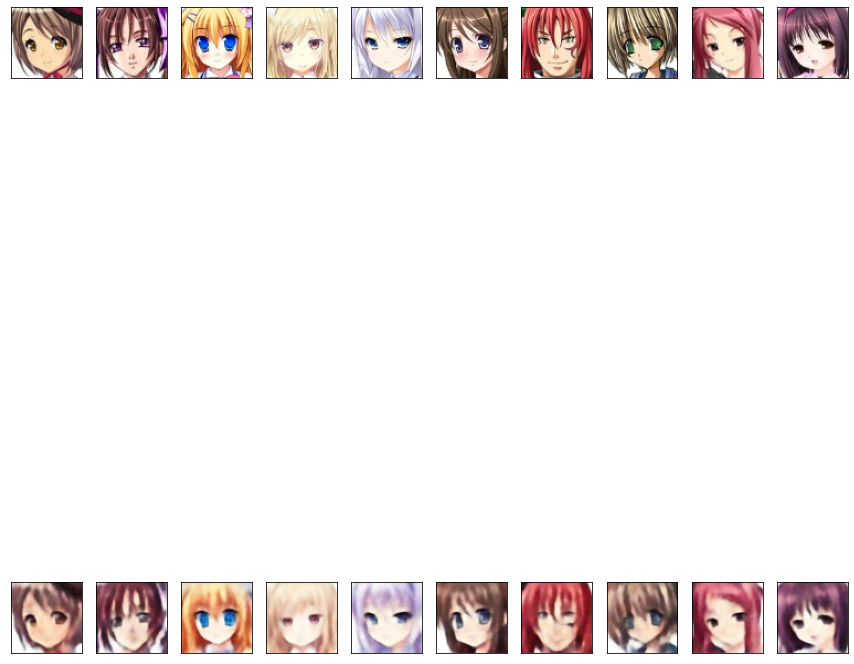

In [ ]:
test_dataset = valid_dataset.take(1)
output_samples = []

for input_image in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.random.choice(64, size=10)

vae_predicted = vae.predict(test_dataset)
display_results(output_samples[idxs], vae_predicted[idxs])

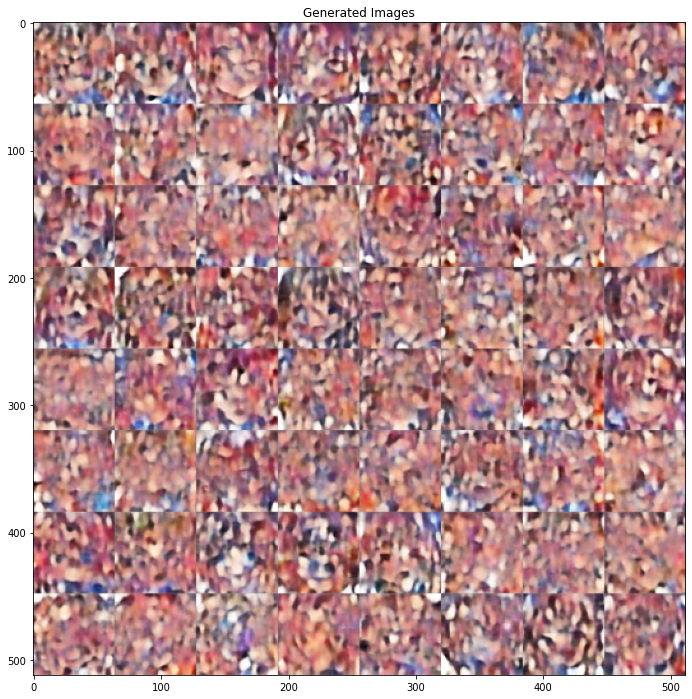

In [ ]:
def plot_images(rows, cols, images, title):
    '''Displays images in a grid.'''
    grid = np.zeros(shape=(rows*64, cols*64, 3))
    for row in range(rows):
        for col in range(cols):
            grid[row*64:(row+1)*64, col*64:(col+1)*64, :] = images[row*cols + col]

    plt.figure(figsize=(12,12))       
    plt.imshow(grid)
    plt.title(title)
    plt.show()

# initialize random inputs
test_vector_for_generation = tf.random.normal(shape=[64, LATENT_DIM])

# get predictions from the decoder model
predictions= decoder.predict(test_vector_for_generation)

# plot the predictions
plot_images(8,8,predictions,'Generated Images')

In [ ]:
import imageio
import glob

anim_file = 'Fmnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
vae.save("anime.h5")